### Things you already know! 
* aim to separate the data and group them into classes
* information gain is the difference between parent entropy and child entropy
* a series of if-else statements
* 3 nodes
    * root, interior and leaf
* at each step we want to decrease the entropy
* each feature is looked at individually for each step
    * each step, information gain/gini index is calculate for each feature
    * tree populates the node with the feauture that has the best score
* what's being observed in the root node? 
    * all the training data, then picks a feature to split on
    * splits our training data
* for the next nodes what's being observed?
    * now you calculate scores for the subsets of data and repeat
* multicollinearity could matter with feature importance
* the training process can be generalized as recursive
* the last nodes of every branch of a decision tree are called leaf nodes

### Questions 
* What's a good scenario to use a decision trees? 
* When you want to investigate feature importance? 
* The feature importance can lead the EDA process
* It's a fast testing process but slow to train
* A lot of features - it's a good first step, but it's computationally expensive
* You never really need to calculate entropy by hand


### Some important concepts
* hyperparameter tuning is huge, because of the amount of hyperparameters
* tuning using a confusion matrix
* tuning using a specific metric

### Objectives
* Build a decision tree classifier using sklearn
* Analyze and improve decision tree classifier iteratively
* Apply best practices to decision trees

### What are the parts of a decision tree?
Nodes and Edges

<img src="decision-tree.jpeg" width="50%"/>

# The Scenario
- You are given the following data and asked to predict if someone will play outside or not based on the features

<img src="data.png" width="50%"/>

In [3]:
# Data Description
"""
Outlook: Sunny, Overcase, Rain
Temp: Hot, Mild, Cool
Humidity: High, Normal
Wind: Weak, Strong

Target
Play: Yes, No
"""
print()

### What is a Gini Index and What is Entropy?

We start a decision tree, the first thing to make is our root node. 

How do we determine which feature will be the root node? We calculate gini index for each feature. 


Then we use the feature with the best gini index

In [4]:
# Calculate the gini index for humidity (high (1)  or normal (0))
# gini index -> purity of a split (are we dividing play_yes and play_no well?)
# 0 = normal, 1 = high
no_play_humidity =  [1, 1, 0, 1, 1] # P(High Humidity|0) = 0.80
yes_play_humidity =  [1, 1, 0, 0, 0, 0, 0, 1, 0] # P(High Humidity|1) = 3/9 = 0.33...


# P(normal humidity|no play)
no_normal = 0.20 # 1 out 5 -> 0.20^2 = 0.04
# P(high humidity | no play) 
no_high = 0.80 # 4 out of 5 -> 0.80^2 = 0.64

# P(normal humdity | yes play)
yes_normal = 6.0/9.0 # 0.6666....
# P(high humidity | yes play)
yes_high = 3.0/9.0 # 0.33333.....



# calculate the purity of the 'no' data
g_nos = no_normal**2 + no_high**2  # 0.68
g_nos_max = 1 # if no_normal = 1 and no_high = 0
g_nos_min = 0.5 # if no_normal = 0.5 and no_high = 0.5 -> worst case scenario




# what does it mean if g_nos << 1
# the feature is evenly represented in our target (which is bad)

# what does it mean if g_nos~1?
# splitting our target and looking at our feature, we see a feature value that is more dominant



# g ~ 1 both numbers must be small (close)
# g ~ 0 one condition has really high probability
g_nos = 1 - g_nos

g_yes = yes_normal**2 + yes_high**2 # 0.5555....
g_yes = 1 - g_yes


# gini ~ 1 this means really really impure split
# gini ~ 0 this means really really pure split
# weighted average
gini = g_nos * (5/14) + g_yes * (9/14)
print("g_humid = {}".format(gini))

g_humid = 0.3999999999999999


# Are there any pros/cons that you're noticing with this? 
* Pros
    * Columns don't necessarily need to be independent (but in ds you want them to be)
    * Multicollinearity is no longer a thing
* Cons
    * Low sample size leads to high variability
    * Low sample sizes leads to bias
    * Greedy/Overfitting

### Outline
* Discuss Gini Index/Entropy
* Build a Decision Tree
* Visualize It

In [5]:
import pandas as pd
import numpy as np

import scipy

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest


import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def create_df_load_set(load_set):
    dataset = load_set()
    data = dataset.data
    columns = dataset.feature_names
    target = dataset.target
    target_names = dataset.target_names
    df = pd.DataFrame(data, columns=columns)
    df['target'] = target
    df['target_names'] = [target_names[i] for i in target]
    return df

In [7]:
df = create_df_load_set(load_iris)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


/Users/rafael/anaconda3/envs/flatiron-env/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


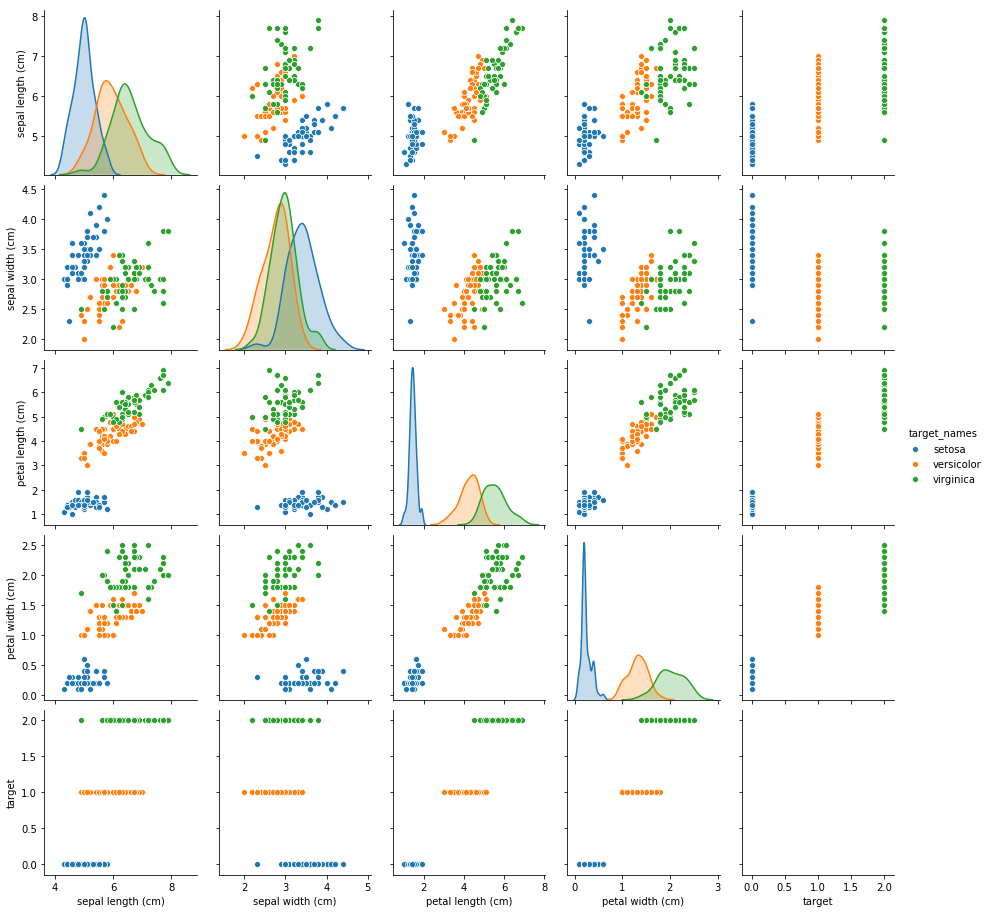

In [8]:
sns.pairplot(data=df, hue='target_names')
plt.show()

In [8]:
df.target_names.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

### Let's discuss multicollinearity of decision trees

In [10]:
df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


### What do we notice about the correlation matrix?

In [88]:
x, y = df.drop(['target', 'target_names'], axis=1), df.target_names

In [89]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.80)

### Let's build a decision tree
* the deeper the tree the more prone to overfitting - literally chasing down every point 

In [51]:
clf = DecisionTreeClassifier() # Betty Crocker DT
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [52]:
clf.score(xtrain, ytrain)

1.0

In [53]:
clf.score(xtest, ytest) # train score = 100% -> overfitting on training data


0.9

### Let's visualize our tree
[Source is Medium Article](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)

In [54]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import pydotplus

In [55]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target', 'target_names'],
      dtype='object')

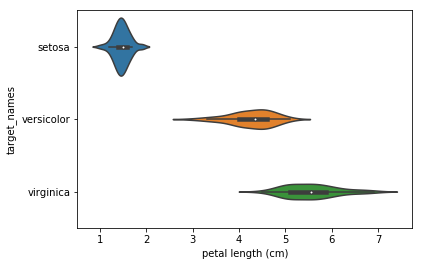

In [56]:
col = df.columns[2]
sns.violinplot(x=col, y='target_names', data=df)

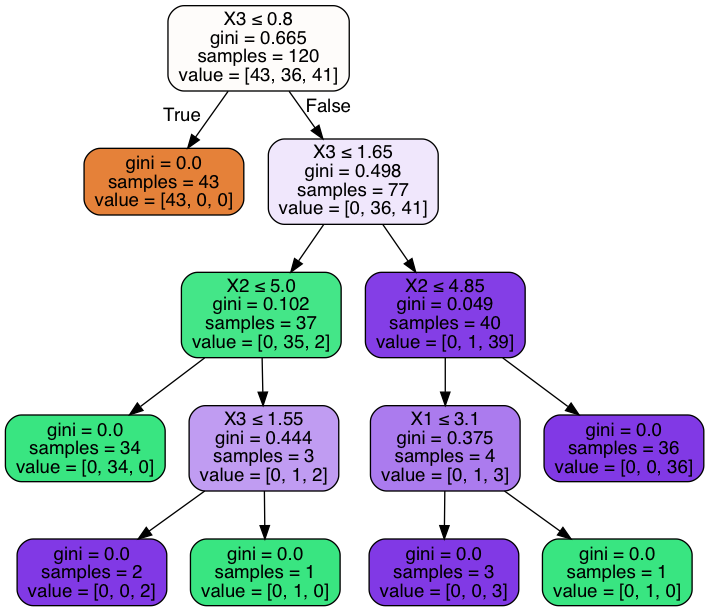

In [57]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### the depth of the search is leading overfitting
### the multicollinearity could lead to overfitting...lead bias

### If you're increasing robustness but test score stays stagnant, what does this indicate?

### Let's tune some hyperparameters

In [64]:
clf = DecisionTreeClassifier(min_samples_leaf=int(xtrain.shape[0]/5))
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=24, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [65]:
clf.score(xtrain, ytrain)

0.975

In [66]:
clf.score(xtest, ytest) # train score = 96% -> overfitting on training data

0.9

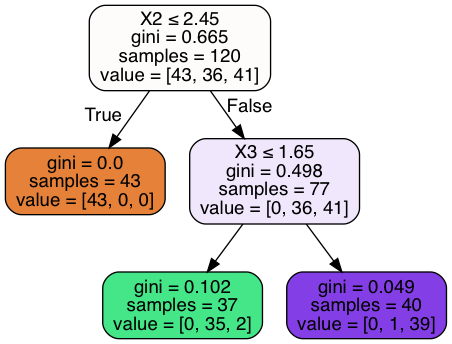

In [67]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [63]:
xtrain.shape

(120, 4)

### Still have splits that are overfitting 'chasing' points.

In [78]:
xtrain.drop(columns=['petal length (cm)'], inplace=True)
xtest.drop(columns=['petal length (cm)'], inplace=True)

/Users/rafael/anaconda3/envs/flatiron-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [79]:
clf = DecisionTreeClassifier(criterion='gini', 
                             min_samples_leaf=int(xtrain.shape[0]/10), 
                             max_depth=3)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [80]:
clf.score(xtrain, ytrain)

0.975

In [81]:
clf.score(xtest, ytest) # train score = 96% -> overfitting on training data

0.9

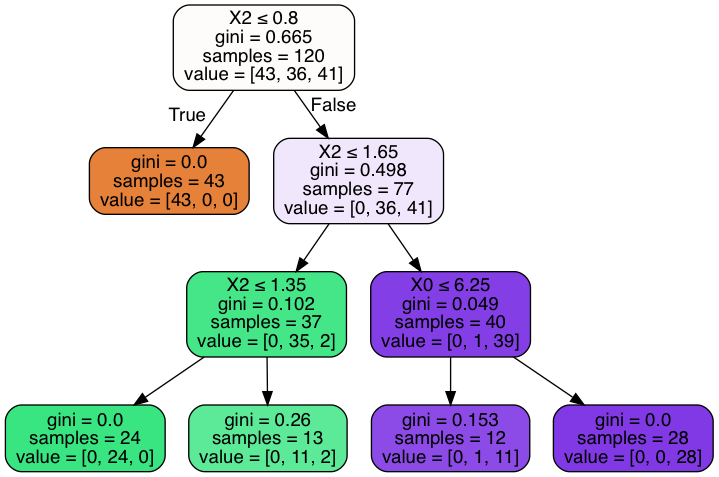

In [82]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### We tuned some hyperparameters, now let's look at attributes

In [84]:
feature_importance_vals = clf.feature_importances_
features = xtrain.columns
feature_importance_vals, features

(array([0.00156462, 0.        , 0.99843538]),
 Index(['sepal length (cm)', 'sepal width (cm)', 'petal width (cm)'], dtype='object'))

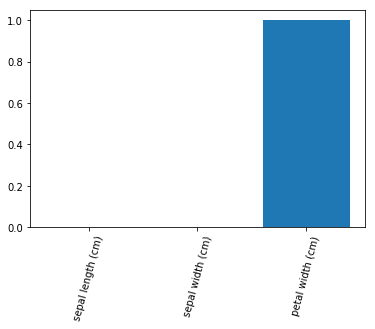

In [85]:
plt.bar(features, feature_importance_vals)
plt.xticks(features, features, rotation=75)
plt.show()

# A typical thing to do at this point
# Is to do a gridsearchcv

In [86]:
from sklearn.model_selection import GridSearchCV

In [87]:
dt = DecisionTreeClassifier()

In [94]:
params = {"criterion":['gini', 'entropy'],
          "splitter":['best', 'random'],
          "max_depth":[3, 5, 10],
          "min_samples_split":[5, 10, 20]}

In [95]:
gs_dt = GridSearchCV(dt, param_grid=params, n_jobs=-1, verbose=2, cv=5)

In [96]:
gs_dt.fit(x, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [98]:
dt_best = gs_dt.best_estimator_

In [99]:
dt_best.score(xtrain, ytrain), dt_best.score(xtest, ytest)

(0.975, 0.9666666666666667)

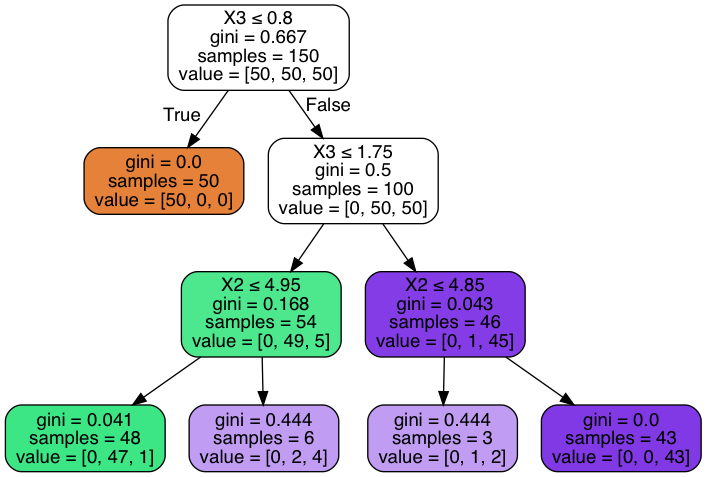

In [100]:
dot_data = StringIO()
export_graphviz(dt_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [50]:
from sklearn.preprocessing import OneHotEncoder

In [51]:
encoder = OneHotEncoder()

In [60]:
encoder.fit(y.values.reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [64]:
ytest_enc = encoder.transform(ytest.values.reshape(-1, 1))
ytest_enc

<30x3 sparse matrix of type '<class 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [65]:
y_score = clf.predict_proba(xtest)
y_score

array([[0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.86666667, 0.13333333, 0.        ],
       [0.86666667, 0.13333333, 0.        ],
       [0.        , 0.57142857, 0.42857143],
       [0.        , 1.        , 0.        ],
       [0.        , 0.57142857, 0.42857143],
       [0.86666667, 0.13333333, 0.        ],
       [0.        , 0.57142857, 0.42857143],
       [0.86666667, 0.13333333, 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.57142857, 0.42857143],
       [0.        , 0.        , 1.        ],
       [0.86666667, 0.13333333, 0.        ],
       [0.        , 0.57142857, 0.42857143],
       [0.86666667, 0.13333333, 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.57142857, 0.42857143],
       [0.        , 0.57142857, 0.42857143],
       [0.86666667, 0.13333333, 0.        ],
       [0.86666667, 0.13333333, 0.        ],
       [0.86666667, 0.13333333, 0.        ],
       [0.

In [70]:
setosas = ytest_enc[:, 0]

In [79]:
setosas.todense().ravel()
y_score[:, 0]

array([0.        , 0.        , 0.86666667, 0.86666667, 0.        ,
       0.        , 0.        , 0.86666667, 0.        , 0.86666667,
       0.        , 0.        , 0.        , 0.86666667, 0.        ,
       0.86666667, 0.        , 0.        , 0.        , 0.86666667,
       0.86666667, 0.86666667, 0.        , 0.        , 0.86666667,
       0.86666667, 0.        , 0.        , 0.86666667, 0.        ])

In [80]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(3):
    actuals = ytest_enc[:, i]
    actuals = actuals.todense().ravel()
    fpr[i], tpr[i], _ = roc_curve(actuals, y_score[:, i].ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: multilabel-indicator format is not supported

### Multicollinearity makes feature importances impossible to interpret

In [127]:
scipy.sparse.csr_matrix.todense(clf.decision_path(xtest)) # SHOWS THE NODES THAT INTERACT WITH EACH X VALUE AS 1

matrix([[1, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 0]])

In [16]:
xtest.shape

(30, 4)

In [17]:
xtest.iloc[0]

sepal length (cm)    6.0
sepal width (cm)     2.2
petal length (cm)    5.0
petal width (cm)     1.5
Name: 119, dtype: float64

In [18]:
clf.predict(xtest.iloc[0].values.reshape(1, -1))

array([1])

### Assessment
* Learned about overfitting decision trees - prone to overfitting
* Tuning hyperparameters
* Pruning the tree can prevent overfitting
    * Prune by limiting depth or limiting splits size requirements
* Assessing and taking actions from feature importances